<a href="https://colab.research.google.com/github/wonyoung-ji/asiae_edu/blob/master/fintech/200917_%EB%84%A4%EC%9D%B4%EB%B2%84_DataLab_CJ_ENM_%EC%A3%BC%EA%B0%80_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __네이버 데이터랩과 주가분석__
  - 검색어 트렌드 분석을 통해 검색어 증가에 따른 주가변동을 분석한다.
  - 마케팅 효과에 따른 검색어 증가량의 변동을 분석한다.
  - 검색어 증가를 통해 마케팅의 수명은 어느정도인지 관리한다.
  - 경쟁사의 검색어 데이터를 통해 경쟁사 마케팅의 파급효과를 분석한다.
  - reference: https://developers.naver.com/docs/datalab/search/#python

# 1.라이브러리 설치

In [14]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

In [37]:
import json
import os
import sys
import urllib.request

# 2.네이버 DataLab 검색량 추출 함수 정의

In [38]:
nid= '52vIBt7gRjMAHREje_XB'
nkey= 'BNbzV6Ygv6'

## 2.1. makeQry 함수 정의
- 검색량 추출을 위한 body를 정의하는 함수

In [39]:
def makeQry(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date'):
  res=[]
  for words in keywords:
    dict = {'groupName':words[0],'keywords':words}
    res.append(dict)
  rdict = {"startDate":sday,
    "endDate":eday,
    "timeUnit":tunit,
    "keywordGroups":res
    }
  return json.dumps(rdict,ensure_ascii=False)         #  Python의 객체를 JSON 문자열로 변환

## 2.2. Mysearch 함수 정의
- 검색량을 출력하는 함수

In [40]:
def Mysearch(keywords=[], sday='2019-01-01',eday='2020-08-30',tunit='date'):
  client_id = nid
  client_secret = nkey 
  url = "https://openapi.naver.com/v1/datalab/search";
 
  body= makeQry(keywords,sday,eday,tunit)
  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()

  if (rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    # print(res)
  else:
    res='error'
    print("Error Code:" + rescode)
  return res

## 2.3. MyDataLab 함수 정의
- 다중 키워드의 검색량을 데이터 프레임으로 병합시키는 함수

In [41]:
def MyDataLab(keywords,sday='2019-01-01',eday='2020-08-30',tunit='date'):
  res = Mysearch(keywords,sday, eday, tunit)
  jdata = json.loads(res)
  i = 0
  maindf = pd.DataFrame()
  for words in keywords:
    pdata = jdata['results'][i]['data']
    df = pd.DataFrame.from_dict(pdata)
    df.columns=['period',words[0]]
    df = df.set_index('period')
    maindf = pd.merge(maindf,df,how='outer',left_index=True,right_index=True)
    i+=1
  return maindf

# 3.CJ ENM 주가분석

## 3.1. CJ ENM 주식데이터 가져오기
- BigQuery에 있는 데이터를 불러온다

In [42]:
import pandas as pd
from pandas.io import gbq

project_id = 'decisive-clover-286903'
sql = """
    SELECT SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL
    FROM `NaverStock.CJENM`
    Where SDAY >= 20190101 and SDAY <= 20200830
    ORDER BY SDAY asc
    """
cjenm = pd.read_gbq(sql, project_id=project_id, dialect='standard')
cjenm.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL
0,20190102,202700.0,202900.0,196500.0,196500.0,58208.0
1,20190103,196700.0,197500.0,190200.0,191200.0,69363.0
2,20190104,191200.0,192500.0,187400.0,191500.0,70378.0
3,20190107,192600.0,199400.0,192200.0,199400.0,64370.0
4,20190108,199500.0,200100.0,195600.0,195800.0,38965.0


## 3.2. CJ ENM의 주식과 검색량의 관계
- 2019.01.01 ~ 2020.08.30 주식을 가져온다.
- 동일한 기간의 네이버 데이터랩 검색량을 불러온다
- 위 둘을 합친다

In [43]:
cjenm['period'] = [str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in cjenm['SDAY']]
cjenm = cjenm.set_index('period')
cjenm.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL
period,,,,,,
2019-01-02,20190102,202700.0,202900.0,196500.0,196500.0,58208.0
2019-01-03,20190103,196700.0,197500.0,190200.0,191200.0,69363.0
2019-01-04,20190104,191200.0,192500.0,187400.0,191500.0,70378.0
2019-01-07,20190107,192600.0,199400.0,192200.0,199400.0,64370.0
2019-01-08,20190108,199500.0,200100.0,195600.0,195800.0,38965.0


In [44]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
mdf = MyDataLab(keywords,'2019-01-01','2020-08-30','date')
mdf.head()

,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,
2019-01-01,0.51273,0.03758,0.01178,0.15669,0.14547
2019-01-02,0.59014,0.03655,0.01355,0.14220,0.11658
2019-01-03,0.57528,0.02870,0.00981,0.11350,0.10892
2019-01-04,5.09767,0.02758,0.01552,0.12453,0.10172
2019-01-05,1.13232,0.03300,0.01299,0.14248,0.08695


In [45]:
alldf = pd.merge(cjenm,mdf,how='outer',left_index=True, right_index=True)
alldf.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.51273,0.03758,0.01178,0.15669,0.14547
2019-01-02,20190102.0,202700.0,202900.0,196500.0,196500.0,58208.0,0.59014,0.03655,0.01355,0.14220,0.11658
2019-01-03,20190103.0,196700.0,197500.0,190200.0,191200.0,69363.0,0.57528,0.02870,0.00981,0.11350,0.10892
2019-01-04,20190104.0,191200.0,192500.0,187400.0,191500.0,70378.0,5.09767,0.02758,0.01552,0.12453,0.10172
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1.13232,0.03300,0.01299,0.14248,0.08695


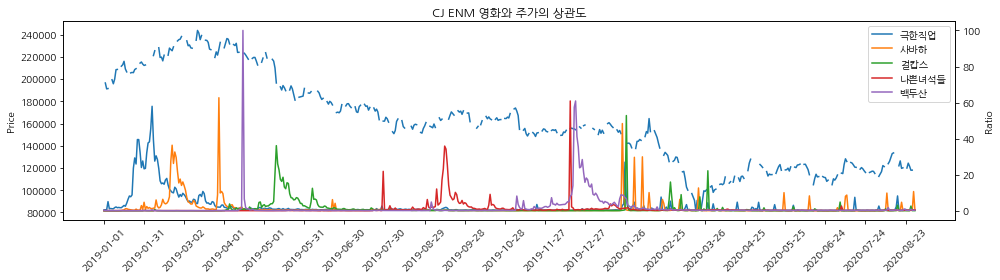

In [46]:
import numpy as np

setdf = alldf[['극한직업','사바하','걸캅스','나쁜녀석들','백두산']]
setdf.head()

xtic = np.arange(0, len(alldf.index), step=30)
xdays = [ alldf.index[i] for i in xtic]

plt.rcParams["figure.figsize"] = (14,4)
fig, ax1 = plt.subplots()
plt.xticks(xtic, rotation=45)

ax1.plot(alldf['CLOSEP'])
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.set_ylabel('Ratio')
setdf.plot(ax=ax2)
plt.title('CJ ENM 영화와 주가의 상관도')
fig.tight_layout()

alldf.interpolate()
plt.show()

# 4.MyDBLab 함수 정의
- 원하는 회사의 주식데이터와 검색량데이터를 합치는 함수

In [54]:
def MyDBLab(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date',sname='CJENM'):
  # 네이버DataLab 검색량 데이터 추출
  mdf=MyDataLab(keywords, sday ,eday, tunit)

  # 쿼리문 대입하기 위해 문자열 수정
  sdaycode = sday.replace('-','')
  edaycode = eday.replace('-','')

  # SQL문 생성
  whsrc = 'SELECT SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL FROM `NaverStock.{}` Where SDAY >= {} and SDAY <= {} ORDER BY SDAY asc'
  sql = whsrc.format(sname, sdaycode, edaycode)

  # 빅쿼리에서 주식데이터 추출 후 정제
  df = pd.read_gbq(sql, project_id=project_id, dialect='standard')
  df['period'] = [str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in df['SDAY']]
  dfstock = df.set_index('period')

  # (주식데이터) + (네이버 DataLab 검색량 데이터)
  alldf = pd.merge(dfstock,mdf,how='outer',left_index=True, right_index=True)

  #선형보간
  alldf= alldf.interpolate()

  return alldf

- MyDBLab 함수를 이용하여 데이터 추출 및 시각화

In [55]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
alldf = MyDBLab(keywords,'2019-01-01','2020-08-30','date','CJENM')
alldf.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.51273,0.03758,0.01178,0.15669,0.14547
2019-01-02,20190102.0,202700.000000,202900.0,196500.0,196500.000000,58208.000000,0.59014,0.03655,0.01355,0.14220,0.11658
2019-01-03,20190103.0,196700.000000,197500.0,190200.0,191200.000000,69363.000000,0.57528,0.02870,0.00981,0.11350,0.10892
2019-01-04,20190104.0,191200.000000,192500.0,187400.0,191500.000000,70378.000000,5.09767,0.02758,0.01552,0.12453,0.10172
2019-01-05,20190105.0,191666.666667,194800.0,189000.0,194133.333333,68375.333333,1.13232,0.03300,0.01299,0.14248,0.08695


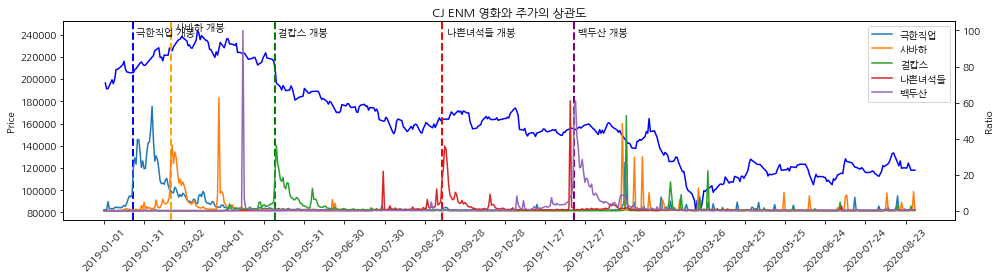

In [56]:
plt.rcParams["figure.figsize"] = (14,4)
fig, ax1 = plt.subplots()

# 주가 그래프
ax1.plot(alldf['CLOSEP'],c='b')

ax1.axvline(x='2019-01-23',label='극한직업 개봉', c="b", linestyle='--',  linewidth=2)         # 극한직업 개봉일 2019년 1월 23일
plt.text(24,240000,"극한직업 개봉")
ax1.axvline(x='2019-02-20',label='사바하 개봉',color='orange',linestyle='--',  linewidth=2)    # 사바하 개봉일 2019년 2월 20일
plt.text(53,245000,"사바하 개봉")
ax1.axvline(x='2019-05-09',label='걸캅스 개봉',color='green',linestyle='--',  linewidth=2)     # 걸캅스 개봉일 2019년 5월 9일
plt.text(130,240000,"걸캅스 개봉")
ax1.axvline(x='2019-09-11',label='나쁜녀석들 개봉',c='r',linestyle='--',  linewidth=2)         # 나쁜녀석들 개봉일 2019년 9월 11일
plt.text(257,240000,"나쁜녀석들 개봉")
ax1.axvline(x='2019-12-19',label='백두산 개봉',color='purple',linestyle='--',  linewidth=2)    # 백두산 개봉일 2019년 12월 19일
plt.text(355,240000,"백두산 개봉")
ax1.set_ylabel('Price')
plt.xticks(xtic, rotation=45)

# 네이버 DataLab 검색량 그래프
ax2 = ax1.twinx()
ax2.set_ylabel('Ratio')
setdf.plot(ax=ax2)

# 그래프 레이아웃 설정
plt.title('CJ ENM 영화와 주가의 상관도')
fig.tight_layout()
plt.show()

# 5.PltDBLab 함수 정의
- MyDBLab을 바탕으로 시각화한다

In [87]:
def PltDBLab(alldf, keywords, xstep=10, ptitle='CJ ENM 영화와 주가의 상관도'):

  xtic = np.arange(0, len(alldf.index), step=xstep)
  xdays = [ alldf.index[i] for i in xtic ]
  set_df=pd.DataFrame()
  for words in keywords:
    set_df=pd.concat((set_df, alldf[words]), axis=1)

  plt.rcParams["figure.figsize"] = (16,8)
  fig, ax1 = plt.subplots()

  # 주가 그래프
  ax1.plot(alldf['CLOSEP'],c='b')
  ax1.set_ylabel('Price')
  plt.xticks(xtic, rotation=45)

  # 네이버 DataLab 검색량 그래프
  ax2 = ax1.twinx()
  ax2.set_ylabel('Ratio')
  set_df.plot(ax=ax2)

  # 그래프 레이아웃 설정
  plt.title(ptitle, fontdict={'fontsize':20})
  fig.tight_layout()
  plt.show()

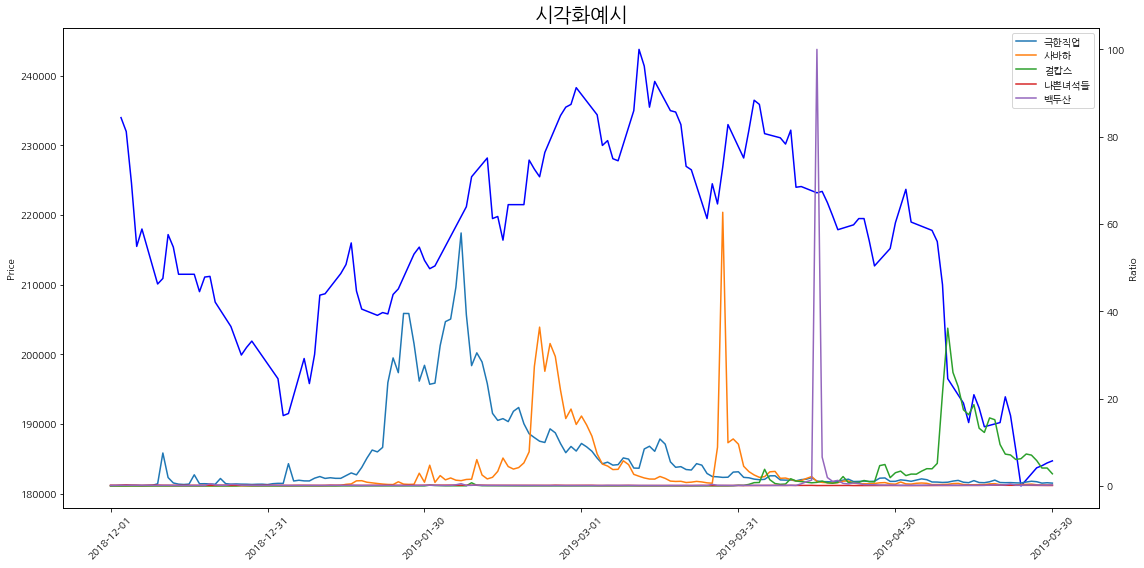

In [88]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
alldf = MyDBLab(keywords,'2018-12-01','2019-05-30','date','CJENM')
PltDBLab(alldf,keywords,30,'시각화예시')

# 5.영화개봉이 주가에 주는 영향 분석 예시
- 극한직업을 예시로 든다.
- 개봉일(2019-01-23)의 앞뒤 2개월 , 총 4개월의 주가를 가져온다

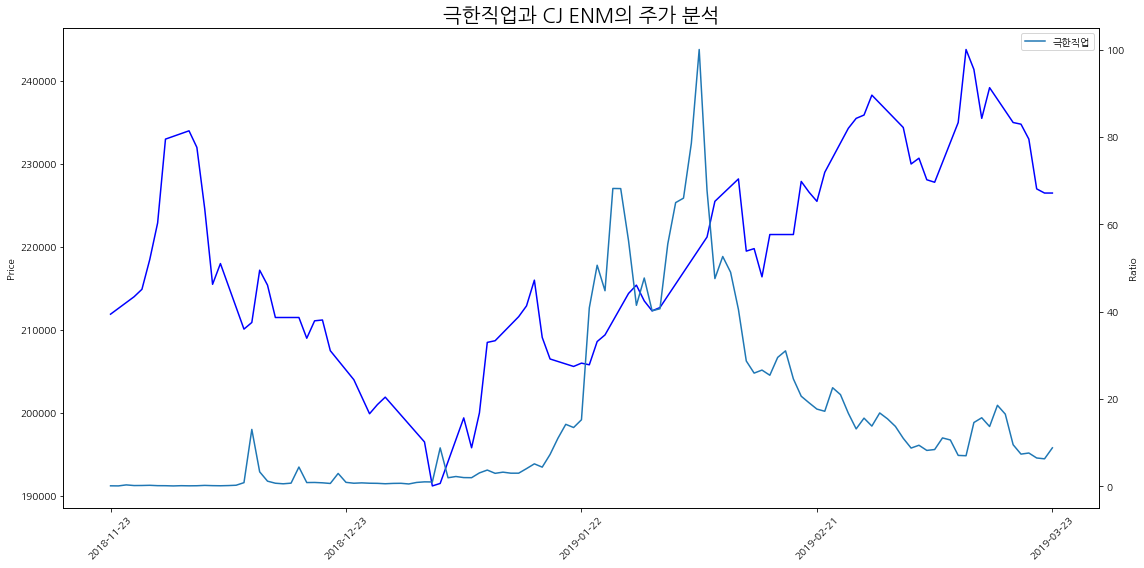

In [99]:
keywords = [['극한직업']]
movie_df = MyDBLab(keywords,'2018-11-23','2019-03-23','date','CJENM')
PltDBLab(movie_df, keywords, xstep=30, ptitle='극한직업과 CJ ENM의 주가 분석')

In [101]:
movie_df[['CLOSEP','극한직업']].corr()

,CLOSEP,극한직업
CLOSEP,1.000000,0.126184
극한직업,0.126184,1.000000


 - 상관계수가 매우 낮게 나왔다.
 - 극한직업 개봉 후 검색어비율은 높게 나왔으나 주가에는 큰 영향을 끼치지는 않은 듯 하다.
 - 2018년 11월 말의 주가와, 2019년 3월 초의 주가가 높이 나온 이유도 들 수 있다.